# **DISSERTATION**

## Project Title: Rice Disease Classification
  **Hispa:**

  Explanation: Rice Hispa is a common pest in rice fields. It is a type of leaf beetle that feeds on rice plants, causing damage to the leaves. The larvae and adults of the Hispa beetle can skeletonize the leaves, leading to a decrease in the plant's photosynthetic capacity and overall health. Pest management strategies are often implemented to control the population of Rice Hispa and minimize its impact on rice crops.

  **Healthy:**

  Explanation: This term simply indicates the desirable condition of rice plants. Healthy rice plants exhibit vigorous growth, with lush green leaves, strong stems, and well-developed panicles (flower clusters). Healthy plants are more resistant to diseases and pests, leading to better yields. Proper crop management practices, including nutrient management, pest control, and irrigation, contribute to maintaining the health of rice plants.

  **Brown Spot:**
  
  Explanation: Brown Spot is a fungal disease that affects rice plants. The disease is caused by the fungus Bipolaris oryzae. It manifests as small, dark brown spots with yellow halos on the leaves. Severe infections can lead to reduced photosynthesis, yield loss, and poor grain quality. Disease-resistant rice varieties, crop rotation, and fungicide applications are some of the measures used to manage and control Brown Spot in rice fields.

  **Leaf Blast:**
  
  Explanation: Rice Blast is one of the most destructive diseases affecting rice crops. It is caused by the fungus Magnaporthe oryzae. The disease can affect all above-ground parts of the rice plant, including leaves, nodes, and panicles. Infected plants show characteristic lesions with a blast-like appearance. Rice Blast can lead to significant yield losses if not properly managed. Planting resistant varieties, applying fungicides, and adopting cultural practices are common strategies for controlling Rice Blast.

In [ ]:
import sys, os, glob, progressbar, shutil
from os import listdir
from os import path
from matplotlib.image import imread
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from collections import Counter
from keras.applications.densenet import DenseNet201
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import seaborn as sns
from sklearn.metrics import roc_curve, auc

root_dir_path = '../input/rice-diseases-image-dataset/LabelledRice/Labelled'

### Data Understanding & Statistics

In [ ]:
def load_data(root_dir_name):
    # Initialize empty lists to store image paths and corresponding labels
    img_paths = []
    labels = []

    # Get a list of class names (subdirectories) in the specified root directory
    class_names = listdir(root_dir_name)

    # Iterate over each class in the dataset
    for class_name in class_names:
        # Construct the full path of the current class directory
        class_path = path.join(root_dir_name, class_name)

        # Get a list of image names in the current class directory
        img_names = listdir(f"{root_dir_name}/{class_name}")

        # Iterate over each image in the current class
        for img_name in img_names:
            # Construct the full path of the current image
            img_path = path.join(root_dir_name, class_name, img_name)

            # Check if the image file has a ".jpg" or ".JPG" extension
            if img_path.endswith(".jpg") == True or img_path.endswith(".JPG") == True:
                # If the image has a valid extension, append its path to the list
                img_paths.append(img_path)

                # Append the corresponding label (class name) to the labels list
                labels.append(class_name)

    # Return the lists of image paths and labels
    return img_paths, labels

# Loading data
img_paths, labels = load_data(root_dir_path)

* Labels analysis

In [ ]:
print("Number of samples in the dataset: ", len(img_paths))
print("Labels: ",set(labels))

Number of samples in the dataset:  3355
Labels:  {'Healthy', 'Hispa', 'LeafBlast', 'BrownSpot'}


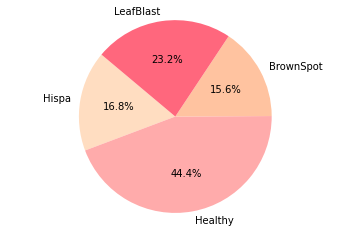

In [ ]:
label_counts = Counter(labels)

# Define light colors for the pie chart
light_colors = ['#FFDDC1', '#FFABAB', '#FFC3A0', '#FF677D', '#D4A5A5', '#392F5A', '#31A2AC', '#61C0BF']

# Plot the pie chart with light colors
plt.pie(label_counts.values(), labels=label_counts.keys(), autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.show()

In [ ]:
label_counts

Counter({'Hispa': 565, 'Healthy': 1488, 'BrownSpot': 523, 'LeafBlast': 779})

The provided dataset consists of labeled instances, where each instance belongs to one of four classes. The classes and their respective counts are as follows:

    Healthy: 1488 instances
        This class likely represents instances in a healthy or normal state, free from any visible diseases or abnormalities.

    Hispa: 565 instances
        This class represents instances affected by a condition referred to as "Hispa." Without additional context, it's not clear what specific disease or issue this label corresponds to.

    BrownSpot: 523 instances
        This class indicates instances affected by a condition known as "BrownSpot." Again, without more information, the specific nature of this condition is not apparent.

    LeafBlast: 779 instances
        Instances in this class are likely affected by a condition referred to as "LeafBlast." Similar to the other classes, further details about the characteristics of LeafBlast would be needed for a more comprehensive understanding.

In [ ]:
img_paths, labels = shuffle(img_paths, labels, random_state=22)

* Lables Mapping

In [ ]:
from sklearn.preprocessing import LabelEncoder

def convert_label_string_to_num(labels):
    # Initialize a LabelEncoder object
    encoder = LabelEncoder()

    # Fit the encoder to the provided labels and transform the labels into numeric values
    numeric_labels = encoder.fit_transform(labels)

    # Create a dictionary mapping original labels to their numeric codes
    label_mapping = dict(zip(labels, numeric_labels))

    # Return the numeric labels, the encoder object, and the label mapping
    return numeric_labels, encoder, label_mapping

# Example usage:
# Assuming 'labels' is your list of string labels
labels, encoder, label_mapping = convert_label_string_to_num(labels)

# Print the label mapping dictionary
print("Label Mapping Dictionary:")
print(label_mapping)

Label Mapping Dictionary:
{2: 2, 1: 1, 3: 3, 0: 0}


* Splitting Data

In [ ]:
def split_data(img_paths, labels):
    # Split the data into training and testing sets
    # img_paths: List of image file paths
    # labels: List of corresponding labels
    # test_size: Fraction of the data to reserve for testing (here, 22%)
    # random_state: Seed for reproducibility
    # stratify: Ensures that the distribution of labels is similar in both training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(img_paths,
                                                      labels,
                                                      test_size=0.22,
                                                      random_state=10,
                                                      stratify=labels)

    # Return the split data
    return x_train, x_test, y_train, y_test

x_train_paths, x_valid_paths, labels_train, labels_valid = split_data(img_paths, labels)

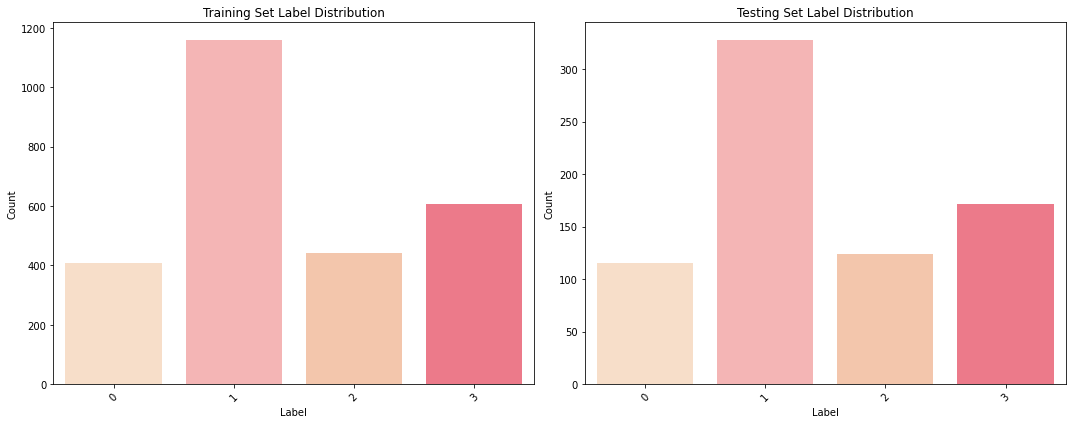

In [ ]:
def plot_label_distribution(labels, title, ax):
    # Define light colors for the bar chart
    light_colors = ['#FFDDC1', '#FFABAB', '#FFC3A0', '#FF677D', '#D4A5A5', '#392F5A', '#31A2AC', '#61C0BF']

    # Plot the distribution of labels using a bar chart with light colors
    label_counts = sns.countplot(x=labels, palette=light_colors, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better visibility

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Generate plots for the training and testing sets
plot_label_distribution(labels_train, title='Training Set Label Distribution', ax=axes[0])
plot_label_distribution(labels_valid, title='Testing Set Label Distribution', ax=axes[1])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


* Reading Images

In [ ]:
NEW_IMG_SIZE = 650
TRAIN_BATCH_SIZE = 20
VAL_BATCH_SIZE = 10

def get_img(img_path, label):
    # Read image file
    img_array = tf.io.read_file(img_path)

    # Decode JPEG image to a 3D tensor (RGB channels)
    img_array = tf.image.decode_jpeg(img_array, channels=3)

    # Convert image to float32
    img_array = tf.cast(img_array, tf.float32)

    # Resize the image with padding to the specified size
    img_array = tf.image.resize_with_pad(img_array, NEW_IMG_SIZE, NEW_IMG_SIZE, method=tf.image.ResizeMethod.AREA)

    return img_array, label

def build_data(x_paths, labels, mode):
    # Create a dataset from the input image paths and labels
    ds = (tf.data.Dataset.from_tensor_slices((x_paths, labels))
          .shuffle(buffer_size=4000)
          .map(get_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .map(lambda x, y: (tf.math.divide(x, 255.0), y))  # Normalize pixel values to [0, 1]
    )

    # Depending on the mode, set up the dataset for training or validation
    if mode == 'train':
        # For training mode, repeat indefinitely, batch, and prefetch for efficiency
        return ds.repeat(None).batch(TRAIN_BATCH_SIZE).prefetch(1)
    else:
        # For validation mode, batch and prefetch for efficiency
        return ds.batch(batch_size=VAL_BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Build datasets for training and validation
train_ds = build_data(x_train_paths, labels_train, mode='train')
valid_ds = build_data(x_valid_paths, labels_valid, mode='validation')

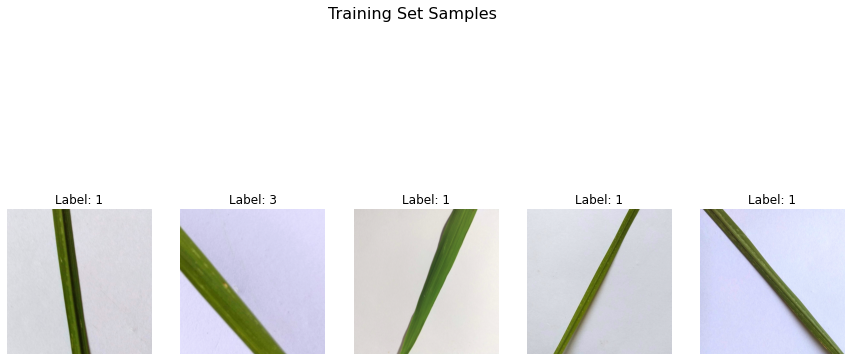

In [ ]:
import matplotlib.pyplot as plt

# Function to display a grid of images with labels
def display_samples(dataset, num_samples=5, title="Sample Images"):
    plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=16)

    # Take a batch from the dataset
    for i, (images, labels) in enumerate(dataset.take(1)):
        # Iterate over individual images and labels
        for j in range(min(num_samples, len(images))):
            plt.subplot(1, num_samples, j + 1)
            plt.imshow(images[j].numpy())
            plt.title(f"Label: {labels[j].numpy()}")
            plt.axis('off')

    plt.show()

# Display samples from the training dataset
display_samples(train_ds, num_samples=5, title="Training Set Samples")


In [ ]:
import numpy as np

# Function to compute and display image statistics
def display_image_statistics(dataset, num_samples=1000):
    # Initialize variables for accumulating statistics
    total_pixels = 0
    total_images = 0
    mean_intensity = 0
    std_dev_intensity = 0

    # Take a subset of the dataset for efficiency
    dataset_subset = dataset.take(num_samples)

    # Iterate over the dataset and accumulate statistics
    for images, _ in dataset_subset:
        total_pixels += np.prod(images.shape[1:])
        total_images += images.shape[0]
        mean_intensity += np.mean(images)
        std_dev_intensity += np.std(images)

    # Compute average values
    avg_shape = total_pixels // total_images
    avg_intensity = mean_intensity / total_images
    avg_std_dev_intensity = std_dev_intensity / total_images

    # Display the statistics
    print(f"Average Shape of Images: {avg_shape}")
    print(f"Average Pixel Intensity: {avg_intensity}")
    print(f"Average Standard Deviation of Pixel Intensity: {avg_std_dev_intensity}")

display_image_statistics(train_ds, num_samples=1000)

Average Shape of Images: 63375
Average Pixel Intensity: 0.039271576568484304
Average Standard Deviation of Pixel Intensity: 0.010941557062417269


### **Tuned - DenseNet Model**

In [ ]:
# Split the data into training and validation sets
x_train_paths, x_valid_paths, labels_train, labels_valid = train_test_split(img_paths, labels, test_size=0.22, random_state=10, stratify=labels)

# Load label encoder
encoder = LabelEncoder()

# Convert string labels to numeric values
labels_train_numeric = encoder.fit_transform(labels_train)
labels_valid_numeric = encoder.transform(labels_valid)

LEARNING_RATE = 0.001
EPOCHS = 30
NUM_CLASSES = len(encoder.classes_)
NEW_IMG_SIZE = 650
TRAIN_BATCH_SIZE = 20
VAL_BATCH_SIZE = 10

# Load DenseNet201 base model
base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=[NEW_IMG_SIZE, NEW_IMG_SIZE, 3])

# Define input layer
inputs = tf.keras.Input(shape=(NEW_IMG_SIZE, NEW_IMG_SIZE, 3))
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.4),
])
out_layer = data_augmentation(inputs)

# Apply DenseNet201 base model
out_layer = base_model(out_layer)

# Global average pooling
out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)

# Dense layer with BatchNormalization and Dropout
out_layer = tf.keras.layers.Dense(units=100, activation='relu')(out_layer)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.Dropout(rate=0.4)(out_layer)

# Output layer
pred = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(out_layer)

# Build the model
model = tf.keras.models.Model(inputs=inputs, outputs=pred)

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

# Training the model
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    steps_per_epoch=len(x_train_paths) // TRAIN_BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1)


Epoch 1/30
130/130 [==============================] - 235s 2s/step - loss: 1.3494 - accuracy: 0.4942 - val_loss: 1.0257 - val_accuracy: 0.6089
Epoch 2/30
130/130 [==============================] - 213s 2s/step - loss: 1.0283 - accuracy: 0.6108 - val_loss: 0.9293 - val_accuracy: 0.6211
Epoch 3/30
130/130 [==============================] - 215s 2s/step - loss: 0.9198 - accuracy: 0.6327 - val_loss: 0.8730 - val_accuracy: 0.6509
Epoch 4/30
130/130 [==============================] - 216s 2s/step - loss: 0.8950 - accuracy: 0.6400 - val_loss: 0.8435 - val_accuracy: 0.6685
Epoch 5/30
130/130 [==============================] - 214s 2s/step - loss: 0.8522 - accuracy: 0.6692 - val_loss: 0.8497 - val_accuracy: 0.6631
Epoch 6/30
130/130 [==============================] - 214s 2s/step - loss: 0.8068 - accuracy: 0.6800 - val_loss: 0.8142 - val_accuracy: 0.6766
Epoch 7/30
130/130 [==============================] - 212s 2s/step - loss: 0.8064 - accuracy: 0.6754 - val_loss: 0.7965 - val_accuracy: 0.6739

In [ ]:
# Display model summary
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 650, 650, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 650, 650, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 20, 20, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1920)              7680      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               192100    
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400 

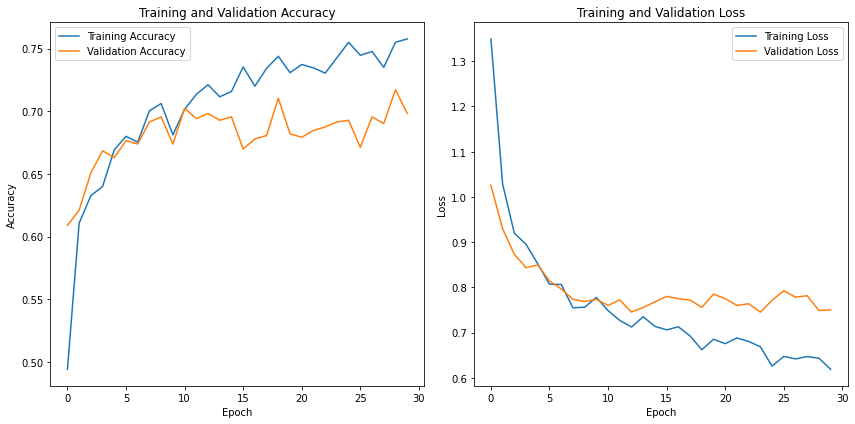

In [ ]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot learning rate changes (if you used a learning rate callback)
if 'lr' in history.history:
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['lr'], label='Learning Rate')
    plt.title('Learning Rate over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.show()


In [ ]:
model.evaluate(valid_ds)

74/74 [==============================] - 55s 745ms/step - loss: 0.7505 - accuracy: 0.6982


[0.7504624128341675, 0.6982408761978149]

    Evaluation Metrics:
        Loss: 0.7505
        Accuracy: 0.6982

    Explanation:

        Loss (0.7505): The loss is a measure of how well the model is performing. It represents a quantity that the model is trying to minimize during training. In general terms, lower loss values indicate better performance.

        Accuracy (0.6982): Accuracy is a common classification metric that represents the ratio of correctly predicted instances to the total number of instances. An accuracy of 0.6982 means that approximately 69.82% of the predictions on the validation dataset were correct.

    Additional Information:
        The output mentions that there are 74 batches (74/74) processed during evaluation.
        The time taken for evaluation is indicated (55s), and the time might vary based on the complexity of the model and the size of the dataset.

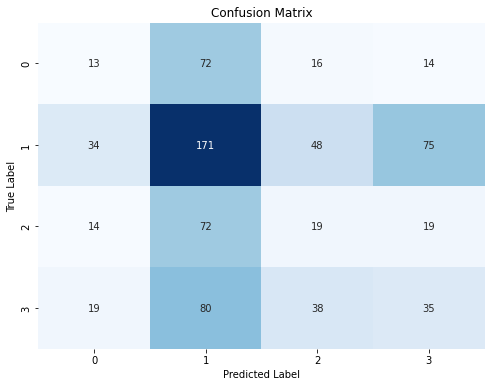

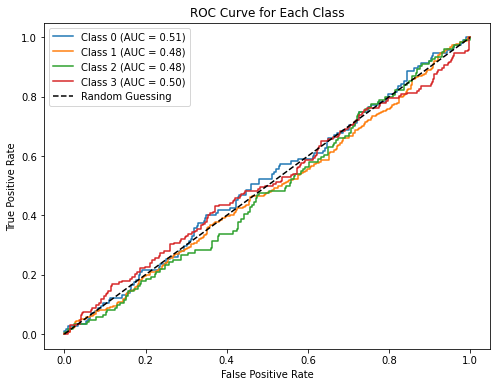

In [ ]:
# Predictions on the validation set
y_pred_prob = model.predict(valid_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_true = labels_valid_numeric  # Assuming you converted labels to numeric earlier

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

class_names = encoder.classes_

# ROC Curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming binary classification (you may need to modify for multiclass)
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.title('ROC Curve for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
confusion_matrix = [
    [13, 72, 16, 14],
    [34, 171, 48, 75],
    [14, 72, 19, 19],
    [19, 80, 38, 35]
]

# Class 0
tp_0 = confusion_matrix[0][0]
tn_0 = sum([sum(confusion_matrix[i][:i] + confusion_matrix[i][i+1:]) for i in range(4)]) - (tp_0 + sum(confusion_matrix[1:][0]))
fp_0 = sum(confusion_matrix[0]) - tp_0
fn_0 = sum(confusion_matrix[0]) - tp_0

# Class 1
tp_1 = confusion_matrix[1][1]
tn_1 = sum([sum(confusion_matrix[i][:i] + confusion_matrix[i][i+1:]) for i in range(4)]) - (tp_1 + sum(confusion_matrix[0] + confusion_matrix[2:][1]))
fp_1 = sum(confusion_matrix[1]) - tp_1
fn_1 = sum(confusion_matrix[1]) - tp_1

# Class 2
tp_2 = confusion_matrix[2][2]
tn_2 = sum([sum(confusion_matrix[i][:j] + confusion_matrix[i][j+1:]) for i in range(4) for j in range(4) if i != 2 and j != 2])
fp_2 = sum(confusion_matrix[2]) - tp_2
fn_2 = sum(confusion_matrix[2]) - tp_2

# Class 3
tp_3 = confusion_matrix[3][3]
tn_3 = sum([sum(confusion_matrix[i][:j] + confusion_matrix[i][j+1:]) for i in range(4) for j in range(4) if i != 3 and j != 3])
fp_3 = sum(confusion_matrix[i][3] for i in range(4) if i != 3) - tp_3
fn_3 = sum(confusion_matrix[3][:3]) - tp_3

# Create lists
tp_list = [tp_0, tp_1, tp_2, tp_3]
tn_list = [tn_0, tn_1, tn_2, tn_3]
fp_list = [fp_0, fp_1, fp_2, fp_3]
fn_list = [fn_0, fn_1, fn_2, fn_3]

print("True Positives:", tp_list)
print("True Negatives:", tn_list)
print("False Positives:", fp_list)
print("False Negatives:", fn_list)

True Positives: [13, 171, 19, 35]
True Negatives: [160, 43, 1332, 1242]
False Positives: [102, 157, 105, 73]
False Negatives: [102, 157, 105, 102]


<ipython-input-11-e80394ba6dc7>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('Blues')


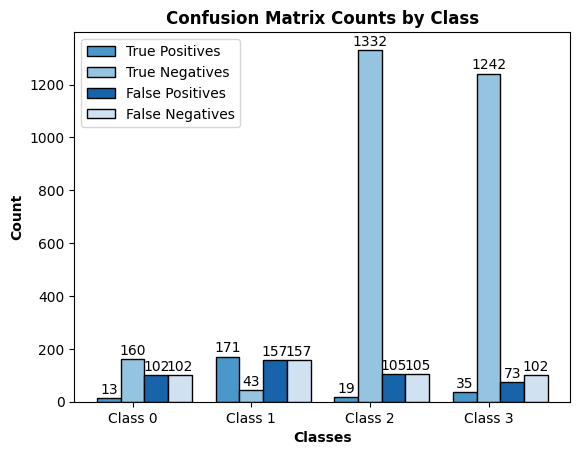

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Bar width
bar_width = 0.2

# Class labels
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

# Set up positions for bars
r1 = np.arange(len(classes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create a single color colormap (e.g., Blues)
cmap = get_cmap('Blues')

# Create grouped bar plot with shades of a single color
plt.bar(r1, tp_list, color=cmap(0.6), width=bar_width, edgecolor='black', linewidth=1, label='True Positives')
plt.bar(r2, tn_list, color=cmap(0.4), width=bar_width, edgecolor='black', linewidth=1, label='True Negatives')
plt.bar(r3, fp_list, color=cmap(0.8), width=bar_width, edgecolor='black', linewidth=1, label='False Positives')
plt.bar(r4, fn_list, color=cmap(0.2), width=bar_width, edgecolor='black', linewidth=1, label='False Negatives')

# Add labels, title, and legend
plt.xlabel('Classes', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(classes))], classes)
plt.ylabel('Count', fontweight='bold')
plt.title('Confusion Matrix Counts by Class', fontweight='bold')
plt.legend()

# Add annotations to each bar
for i in range(len(r1)):
    plt.text(r1[i], tp_list[i] + 5, str(tp_list[i]), ha='center', va='bottom', color='black')
    plt.text(r2[i], tn_list[i] + 5, str(tn_list[i]), ha='center', va='bottom', color='black')
    plt.text(r3[i], fp_list[i] + 5, str(fp_list[i]), ha='center', va='bottom', color='black')
    plt.text(r4[i], fn_list[i] + 5, str(fn_list[i]), ha='center', va='bottom', color='black')

# Show the plot
plt.show()